## Import

In [1]:
import numpy as np
import functions as fc
from timeit import default_timer as time
from fatiando.gravmag import polyprism
from fatiando import mesher, gridder
from fatiando.gravmag import prism
from fatiando.constants import G, SI2MGAL
from scipy.sparse import diags

from matplotlib import pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy.interpolate import griddata
from scipy import interpolate, signal
from fatiando.vis import mpl
import cPickle as pickle
#%matplotlib inline

/home/vanderlei/Documents/fatiando/fatiando/vis/mpl.py:70: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


In [2]:
def plot_rec(bmap, lower_left, upper_left, lower_right, upper_right):
    xs = [lower_left[0], upper_left[0],
          lower_right[0], upper_right[0],
          lower_left[0], lower_right[0],
          upper_left[0], upper_right[0]]
    ys = [lower_left[1], upper_left[1],
          lower_right[1], upper_right[1],
          lower_left[1], lower_right[1],
          upper_left[1], upper_right[1]]
    bmap.plot(xs, ys, latlon = True, color='red')

## Observed Grid and Data

In [3]:
with open('carajas_gz.pickle') as r:
    carajas = pickle.load(r)

In [4]:
grid_x = carajas['x']
grid_y = carajas['y']
grid_z = carajas['z']
grid_dobs = carajas['gz']

In [5]:
gz_max = np.max(grid_dobs)
gz_min = np.min(grid_dobs)

print gz_min, gz_max

-88.25 2.35


In [6]:
gz_colorbar_ranges = np.arange(-90., 6.1, 6)

print gz_colorbar_ranges

[-90. -84. -78. -72. -66. -60. -54. -48. -42. -36. -30. -24. -18. -12.
  -6.   0.   6.]


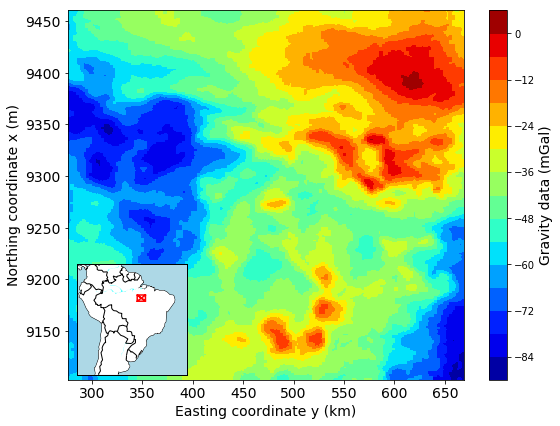

In [7]:
plt.figure(figsize=(8,6))
#plt.plot()
ax=plt.subplot(1,1,1)
plt.tricontourf(np.ravel(grid_y),np.ravel(grid_x),np.ravel(grid_dobs),
                levels=gz_colorbar_ranges, cmap='jet',
                vmin = -90, vmax = 6)

#define colorbar
cbar = plt.cm.ScalarMappable(cmap=cm.jet)
cbar.set_array(np.ravel(grid_dobs))
cbar.set_clim(-90, 6)
cb = plt.colorbar(cbar, shrink=1, boundaries=gz_colorbar_ranges)
cb.set_label('Gravity data (mGal)', rotation=90, fontsize=14)

plt.xlim(np.min(grid_y),np.max(grid_y))
plt.ylim(np.min(grid_x),np.max(grid_x))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()
plt.tight_layout(True)

# plot the inset
#inset = inset_axes(ax, width="40%", height="40%", loc=3, bbox_to_anchor=(65,44,350,350))
inset = inset_axes(ax, width="30%", height="30%", loc=3)
m = Basemap(projection='merc',llcrnrlat=-40,urcrnrlat=10,\
            llcrnrlon=-82,urcrnrlon=-29,lat_ts=20,resolution='c')
m.drawcoastlines(zorder=1)
m.fillcontinents(color='white',lake_color='aqua')
llcrnrlon = -53
urcrnrlon =  -49
llcrnrlat =  -8
urcrnrlat =  -5
lower_left = (llcrnrlon, llcrnrlat)
lower_right= (urcrnrlon, llcrnrlat)
upper_left = (llcrnrlon, urcrnrlat)
upper_right= (urcrnrlon, urcrnrlat)
plot_rec(m, lower_left, upper_left, lower_right, upper_right)

m.drawmapboundary(fill_color='lightblue')
m.drawcountries(linewidth=1, linestyle='solid', color='k' )

plt.savefig('../manuscript/Fig/carajas_real_data.png', dpi=300)

plt.show()

## Equivalent layer Depth

In [8]:
# Equivalent Layer depth
shape_m = (500, 500)
zj = np.ones_like(grid_z)*300

## Fast Eq. Layer Combined with Circulant-Toeplitz (BCCB)

In [9]:
# Predicted data
s = time()
itmax = 50
rho_toep, gzp_toep = fc.fast_eq_bccb(np.ravel(grid_x),np.ravel(grid_y),np.ravel(grid_z),
                                  np.ravel(zj),shape_m,np.ravel(grid_dobs),itmax)
e = time()
tcpu = e - s
print tcpu

1.11918091774


In [10]:
delta_gz = gzp_toep-np.ravel(grid_dobs)

## Property estimative plot

## Data, Predicted data and Residuals plot

## Fast Equivalent layer BCCB plot

In [11]:
mean = np.mean(delta_gz)
print mean
std = np.std(delta_gz)
print std

0.00029344162027741734
0.1158238959637627


In [12]:
print np.min(delta_gz), np.max(delta_gz)

-1.8876473016330095 2.302509214867115


In [19]:
res_colorbar_ranges = np.arange(-0.8, 0.81, 0.1)

In [20]:
res_colorbar_ranges

array([-8.00000000e-01, -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
       -4.00000000e-01, -3.00000000e-01, -2.00000000e-01, -1.00000000e-01,
       -2.22044605e-16,  1.00000000e-01,  2.00000000e-01,  3.00000000e-01,
        4.00000000e-01,  5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
        8.00000000e-01])

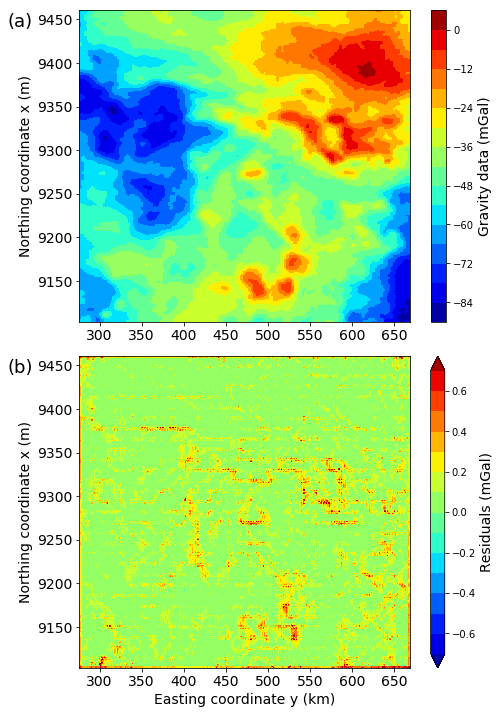

In [21]:
# plot of the vertical component of the gravitational atraction at z=0 
plt.figure(figsize=(7,10))

#plt.subplot(311)
#plt.title('A)', y=0.91, x=0.1, fontsize=18)
#plt.tricontourf(np.ravel(grid_y),np.ravel(grid_x),np.ravel(grid_dobs),15,cmap='jet')
#cb = plt.colorbar()
##plt.axis('scaled')
#cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
#plt.xlim(np.min(yi_c),np.max(yi_c))
#plt.ylim(np.min(xi_c),np.max(xi_c))
#plt.xticks(fontsize=14)
#plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=12)
#plt.ylabel('Northing coordinate x (m)', fontsize=12)
#mpl.m2km()

plt.subplot(211)
plt.title('(a)', y=0.93, x=-0.18, fontsize=18)
plt.tricontourf(np.ravel(grid_y),np.ravel(grid_x),gzp_toep,
                levels=gz_colorbar_ranges, cmap='jet', 
                vmin = -90, vmax = 6)

#define colorbar
cbar = plt.cm.ScalarMappable(cmap=cm.jet)
cbar.set_array(gzp_toep)
cbar.set_clim(-90, 6)
cb = plt.colorbar(cbar, shrink=1, boundaries=gz_colorbar_ranges)
cb.set_label('Gravity data (mGal)', rotation=90, fontsize=14)

plt.xlim(np.min(grid_y),np.max(grid_y))
plt.ylim(np.min(grid_x),np.max(grid_x))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()

plt.subplot(212)
plt.title('(b)', y=0.93, x=-0.18, fontsize=18)
plt.tricontourf(np.ravel(grid_y),np.ravel(grid_x),delta_gz,
                levels=res_colorbar_ranges, vmin=-0.8, vmax=.8, cmap='jet')

#define colorbar
cbar = plt.cm.ScalarMappable(cmap=cm.jet)
cbar.set_array(delta_gz)
cbar.set_clim(-0.8, 0.8)
cb = plt.colorbar(cbar, shrink=1, boundaries=res_colorbar_ranges, extend='both')
cb.set_label('Residuals (mGal)', rotation=90, fontsize=14)

plt.xlim(np.min(grid_y),np.max(grid_y))
plt.ylim(np.min(grid_x),np.max(grid_x))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()
plt.tight_layout(True)
plt.savefig('../manuscript/Fig/Carajas_gz_predito.png', dpi=300)

## Transformation - Upward Continuation

In [16]:
# BTTb Eq. Layer Transformation
N = shape_m[0]*shape_m[1]
z_up = np.zeros_like(grid_x)-5000
s = time()
BTTB_up = fc.bttb(np.ravel(grid_x),np.ravel(grid_y),np.ravel(z_up),np.ravel(zj))
cev_up = fc.bccb(shape_m,N,BTTB_up)
gzp_bccb_up = fc.fast_forward_bccb(shape_m,N,rho_toep,cev_up)
e = time()
tcpu = e - s
print tcpu

0.0597250461578


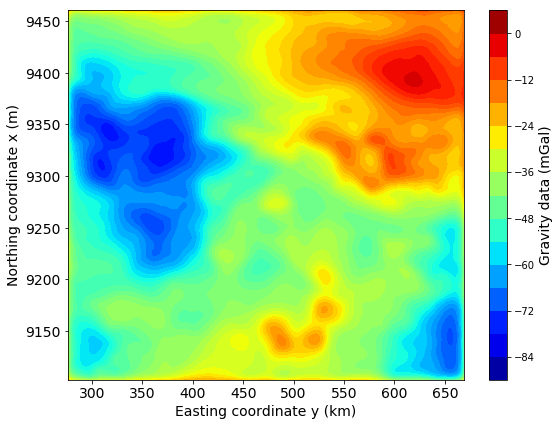

In [17]:
# plot of the vertical component of the gravitational atraction at z=0 
plt.figure(figsize=(8,6))

plt.tricontourf(np.ravel(grid_y),np.ravel(grid_x),gzp_bccb_up,
                30, cmap='jet', vmin = -90, vmax = 6)

#define colorbar
cbar = plt.cm.ScalarMappable(cmap=cm.jet)
cbar.set_array(gzp_bccb_up)
cbar.set_clim(-90, 6)
cb = plt.colorbar(cbar, shrink=1, boundaries=gz_colorbar_ranges)
cb.set_label('Gravity data (mGal)', rotation=90, fontsize=14)

plt.xlim(np.min(grid_y),np.max(grid_y))
plt.ylim(np.min(grid_x),np.max(grid_x))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (m)', fontsize=14)
mpl.m2km()
plt.tight_layout(True)
plt.savefig('../manuscript/Fig/up5000_carajas_500x500.png', dpi=300)
plt.show()

## Transformation - Downward Continuation

In [ ]:
# BTTb Eq. Layer Transformation
N = shape_m[0]*shape_m[1]
z_down = np.zeros_like(grid_x)-500
BTTB_down = fc.bttb(np.ravel(grid_x),np.ravel(grid_y),np.ravel(z_down),np.ravel(zj))
cev_down = fc.bccb(shape_m,N,BTTB_down)
gzp_bccb_down = fc.fast_forward_bccb(shape_m,N,rho_toep,cev_down)

In [ ]:
# plot of the vertical component of the gravitational atraction at z=0 
plt.figure(figsize=(6,6))

plt.tricontourf(np.ravel(grid_y),np.ravel(grid_x),gzp_bccb_down,30,cmap='jet')
cb = plt.colorbar(shrink=0.8)
plt.axis('scaled')
cb.set_label('$Gz$ ( $mGal$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_c),np.max(yi_c))
plt.ylim(np.min(xi_c),np.max(xi_c))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Easting coordinate y (km)', fontsize=12)
plt.ylabel('Northing coordinate x (m)', fontsize=12)
mpl.m2km()
plt.tight_layout(True)
#plt.savefig('figures/down500_carajas_500x500.jpg', dpi=300)
plt.show()

## Transformation - Gzz

In [ ]:
# BTTb Eq. Layer Transformation
w_gzz = fc.bttb_gzz(np.ravel(grid_x),np.ravel(grid_y),np.ravel(grid_z),np.ravel(zj))
gzz = fc.fast_forward_bccb(shape_m,shape_m[0]*shape_m[1],rho_toep,w_gzz)

In [ ]:
# plot of the vertical component of the gravitational atraction at z=0 
plt.figure(figsize=(6,6))

plt.tricontourf(np.ravel(grid_y),np.ravel(grid_x),gzz,30,cmap='jet')
cb = plt.colorbar(shrink=0.8)
plt.axis('scaled')
cb.set_label('$Gzz$ ( $eotvos$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_c),np.max(yi_c))
plt.ylim(np.min(xi_c),np.max(xi_c))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Horizontal coordinate y (m)', fontsize=12)
plt.ylabel('Horizontal coordinate x (m)', fontsize=12)
#plt.savefig('figures/gzz_carajas_1005x131.jpg', dpi=300)
plt.show()

## Junk Tests

In [ ]:
data_right = np.zeros_like(data)
for i in range (shape[1]):
    line = data[i*300:(i+1)*300,:]
    if line[i+1,1] < line[i,1]:
        line_reverse = line[::-1]
        data_right[i*300:(i+1)*300,:] = line_reverse
    else:
        data_right[i*300:(i+1)*300,:] = line